# Asteroid Light Curve Examples - Part 1

This notebook contains examples deep learning techniques applied to the asteroid light curve data from http://alcdef.org.


# Objectives
- Understand when a convolutional neural network (CNN) might be applicable.
- See how to apply a 1D-CNN to time-series data.
- See how to build a more complex model that takes both time-series and categorical inputs.

# Parameters

In [1]:
# Path to the ALCDEF_ALL dataset downloaded from http://alcdef.org
data_dir = 'data/ALCDEF_ALL'

# Discard any light curves with fewer than this many samples
min_samples = 100

# Resample light curves to common number of samples
nb_samples = 100

# Discard any light curve that isn't among the nb_classes most common objects
nb_classes = 20

# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
from scipy.signal import resample
from collections import Counter

import random

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import pandas as pd
import seaborn as sns

from ml4ssa_utils import visualize_embedding, load_alcdef_data, plot_alcdef_examples

Using TensorFlow backend.


# Load Dataset

Load data from Astroid Lightcurve Photometry Database (http://alcdef.org/)

In [3]:
data = load_alcdef_data(
    data_dir=data_dir,
    min_samples=min_samples,
    resample_to=nb_samples,
    reduce_to_top=nb_classes
)

# Visualize Examples

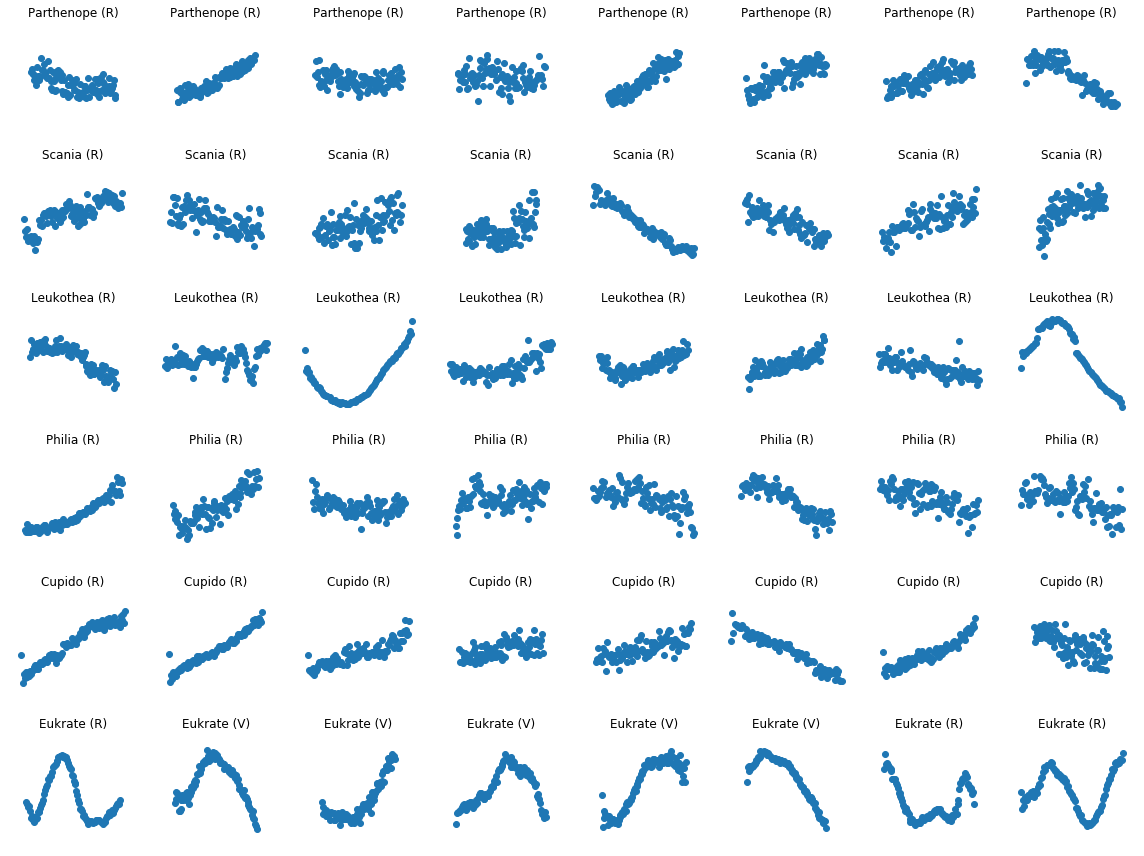

In [4]:
plot_alcdef_examples(data)

# Generate Train and Test Data Sets

In [21]:
X = np.array([ item['DATA_RESAMPLED'][:,1] for item in sub_data ])
y = np.array([ names.index(item['OBJECTNAME']) for item in sub_data ])

# Reserve 20% of the data for testing
# Startify the data split so that the train and test sets have the same class distribution

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print('Generated train and test sets with the following sizes.')
print('Train X (features) {}, y (targets) {}'.format(X_train.shape, y_train.shape))
print('Test  X (features) {}, y (targets) {}'.format(X_test.shape, y_test.shape))

# Compute random accuracy


Generated train and test sets with the following sizes.
Train X (features) (814, 100), y (targets) (814,)
Test  X (features) (204, 100), y (targets) (204,)


## Review Class Distributions to Understand Performance of Random Classifier

It's always helpful to understand how well a random classifier should perform. This sets a worst case baseline. If you're doing better than this performance, you know at least something is working. If your classifier is performing worse than random, something is broken. If it's performing at the same level as random, it's either broken or you have a very hard problem (at least with your current size and distribution of training data).

In [55]:
class_counts = np.sum(to_categorical(y_test), axis=0)
class_proportions = class_counts / np.sum(class_counts)
max_proportion = np.max(class_proportions)
random_performance = 1./nb_classes

print('Random Performance: {:.3f}'.format(1./nb_classes))
print('Mode Collapse Performance: {:.3f}'.format(max_proportion))
print('-'*65)
for name, proportion in zip(names, class_distribution):
    print('{:15} {:.3f} {}'.format(name, proportion, 'largest' if proportion == max_proportion else ''))

Random Performance: 0.033
Mode Collapse Performance: 0.083
-----------------------------------------------------------------
Ganymed         0.083 largest
Parthenope      0.078 
Zelinda         0.044 
Ate             0.044 
Leukothea       0.039 
Eudora          0.039 
Melanie         0.034 
Cupido          0.034 
Scania          0.034 
Eukrate         0.029 
Polyhymnia      0.029 
Philia          0.029 
Norma           0.029 
Lachesis        0.029 
Euterpe         0.029 
Aurelia         0.029 
Aline           0.029 
Pales           0.029 
Ounas           0.029 
Thora           0.029 
Jaroslawa       0.025 
1999 FH         0.025 
Siwa            0.025 
Elsa            0.025 
Petrina         0.025 
Virginia        0.025 
Kalypso         0.025 
Shapleya        0.025 
Laura           0.025 
Adeona          0.025 


# Try an MLP (multi-layer perceptron) similiar to the TLE Example

In [62]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Dense(units=100,activation='relu', input_shape=(100,)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
# model.predict(np.zeros((16,9)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 30)                3030      
Total params: 23,230
Trainable params: 23,230
Non-trainable params: 0
_________________________________________________________________


In [80]:
def plot_confusion_matrix(X,y,title):
    yhat = model.predict(normalize(X))
    cm = confusion_matrix(y, np.argmax(yhat, axis=1))
    a = pd.DataFrame(cm)
    a.columns = names
    a.index = names
    acc = np.trace(cm)/np.sum(cm)
    title_with_acc = '{} (acc: {:.3f})'.format(title, acc)
    
    sns.heatmap(a, cmap=None, annot=True, linewidths=.1).set_title(title_with_acc)    
    

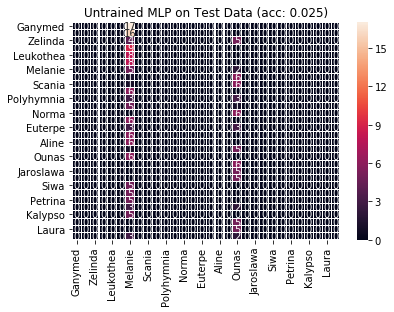

In [81]:
plot_confusion_matrix(X_test, y_test, 'Untrained MLP on Test Data')

In [82]:
repeats = 1
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.

def normalize(X):
    return (X - np.mean(X, keepdims=True)) / np.std(X, keepdims=True)

model.fit(
    normalize(X_train.repeat(repeats, axis=0)),
    to_categorical(y_train.repeat(repeats, axis=0)),
    validation_data=(normalize(X_test), to_categorical(y_test)),
    epochs=5,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    verbose=1
)

Train on 814 samples, validate on 204 samples
Epoch 1/5
814/814 [==============================] - 0s 269us/step - loss: 3.3087 - acc: 0.0651 - val_loss: 3.1183 - val_acc: 0.1127
Epoch 2/5
814/814 [==============================] - 0s 77us/step - loss: 3.0815 - acc: 0.1093 - val_loss: 3.0185 - val_acc: 0.1127
Epoch 3/5
814/814 [==============================] - 0s 77us/step - loss: 3.0242 - acc: 0.1032 - val_loss: 2.9795 - val_acc: 0.1127
Epoch 4/5
814/814 [==============================] - 0s 62us/step - loss: 2.9932 - acc: 0.1020 - val_loss: 2.9532 - val_acc: 0.1127
Epoch 5/5
814/814 [==============================] - 0s 77us/step - loss: 2.9772 - acc: 0.1044 - val_loss: 2.9406 - val_acc: 0.1127


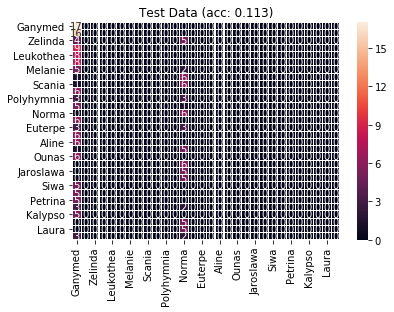

In [83]:
plot_confusion_matrix(X_test, y_test, 'Test Data')

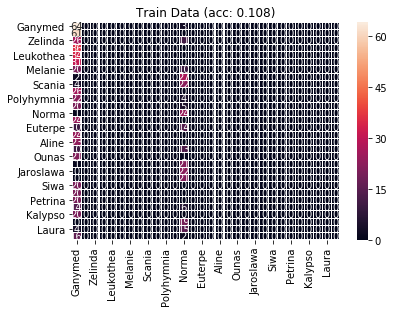

In [84]:
plot_confusion_matrix(X_train, y_train, 'Train Data')

# CNN Model

Now that we have two baselines (random performance and the MLP we used for TLE data), let's look at improving our performance with a different model.

In [89]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 18, 16)            2576      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 30)                510       
Total para

In [108]:
repeats = 10
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.

def normalize(X):
    return (X - np.mean(X, keepdims=True)) / np.std(X, keepdims=True)

model.fit(
    np.expand_dims(normalize(X_train.repeat(repeats, axis=0)), axis=-1),
    to_categorical(y_train.repeat(repeats, axis=0)),
    validation_data=(np.expand_dims(normalize(X_test), axis=-1), to_categorical(y_test)),
    epochs=1000,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, monitor='val_loss')],
    verbose=1
)

Train on 8140 samples, validate on 204 samples
Epoch 1/1000
8140/8140 [==============================] - 146s 18ms/step - loss: 2.3176 - acc: 0.2370 - val_loss: 2.5120 - val_acc: 0.2353
Epoch 2/1000
8140/8140 [==============================] - 146s 18ms/step - loss: 2.2951 - acc: 0.2461 - val_loss: 2.4466 - val_acc: 0.2353
Epoch 3/1000
8140/8140 [==============================] - 145s 18ms/step - loss: 2.2767 - acc: 0.2491 - val_loss: 2.4308 - val_acc: 0.2304
Epoch 4/1000
8140/8140 [==============================] - 143s 18ms/step - loss: 2.2783 - acc: 0.2468 - val_loss: 2.4339 - val_acc: 0.1961
Epoch 5/1000
8140/8140 [==============================] - 146s 18ms/step - loss: 2.2666 - acc: 0.2473 - val_loss: 2.3604 - val_acc: 0.2255
Epoch 6/1000
8140/8140 [==============================] - 145s 18ms/step - loss: 2.2531 - acc: 0.2542 - val_loss: 2.4100 - val_acc: 0.2108
Epoch 7/1000
8140/8140 [==============================] - 144s 18ms/step - loss: 2.2412 - acc: 0.2534 - val_loss: 2.531

KeyboardInterrupt: 

# Light Curve Embedding Based on Extracted Features

__TODO__ : Add a visualization of the intermediate features learned by both the CNN and MLP above.

In [104]:
# Here we extract the intermediate features/activations from the layer named penultimate
layer_name = 'penultimate'
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_penultimate_test = intermediate_layer_model.predict(np.expand_dims(normalize(X_test), axis=-1))

C:\Users\jpula\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


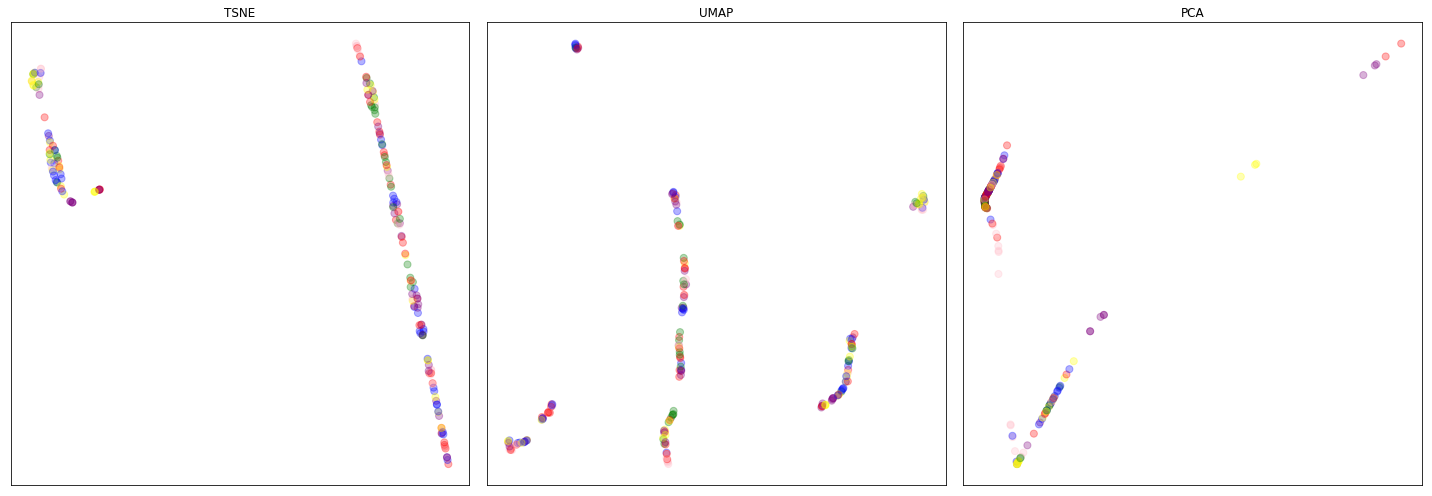

In [105]:
visualize_embedding(X_penultimate_test, y_test)

In [ ]:
plot_confusion_matrix(X_test, y_test, '')